In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

In [11]:
train = pd.read_csv('eletrain.csv')
test = pd.read_csv('test.csv')
train['비전기냉방설비운영'].fillna(0, inplace=True)
train['태양광보유'].fillna(0, inplace=True)
submission = pd.read_csv('sample_submission_ARIMA.csv')
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0,0
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,0,0
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,0,0
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,0,0
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,0,0


,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0,0
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,0,0
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,0,0
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,0,0
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,1,1
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,1,1
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1,1
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,1,1


In [12]:
def df2d_to_array3d(df_2d):
  feature_size = df_2d.iloc[:,2:].shape[1] #특성(전력량, 기온 등)의 개수
  time_size = len(df_2d['date_time'].value_counts()) #시간 개수
  sample_size = len(df_2d.num.value_counts()) #num의 종류? 개수? -> 즉, 건물 몇 개
  return df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size]) # reshape에 인자 넣어주면 알아서 모양 맞춰서 나옴

In [13]:
train_x_array = df2d_to_array3d(train)
test_x_array = df2d_to_array3d(test)
print(train_x_array.shape)
print(test_x_array.shape)

(60, 2040, 8)
(60, 168, 7)


In [14]:
def plot_series(x_series, y_series):
  plt.plot(x_series, label = 'input_series')
  plt.plot(np.arange(len(x_series), len(x_series) + len(y_series)), y_series, label = 'output_series')
  plt.axhline(1, c= 'red')
  plt.legend()

전력사용량 ACF그래프 그려보기
대략 p 5나 6

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (T

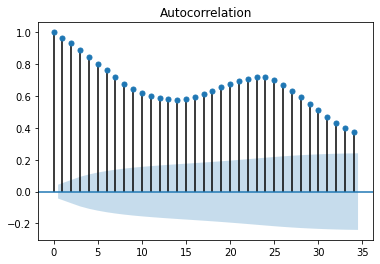

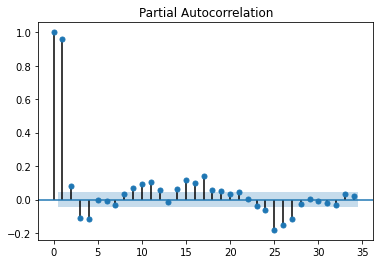

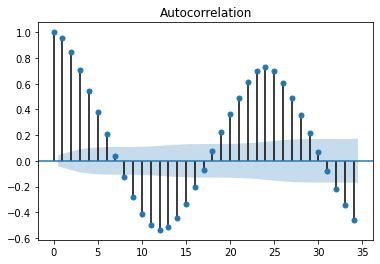

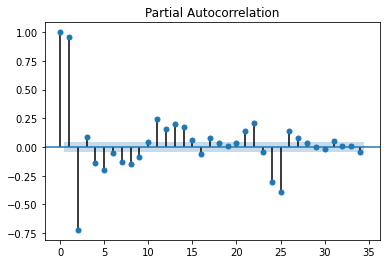

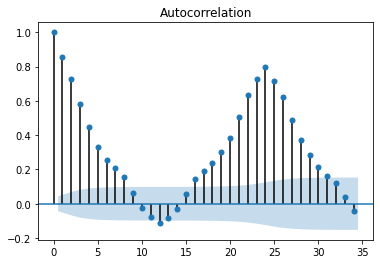

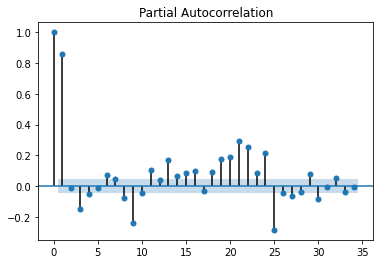

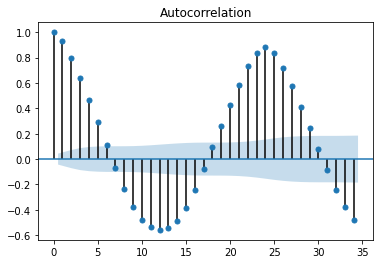

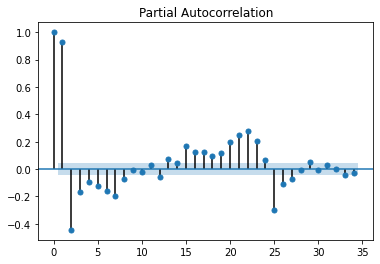

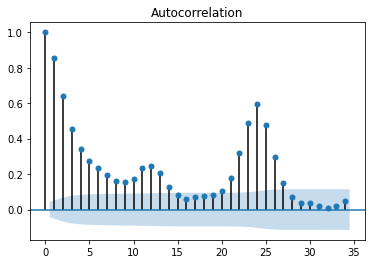

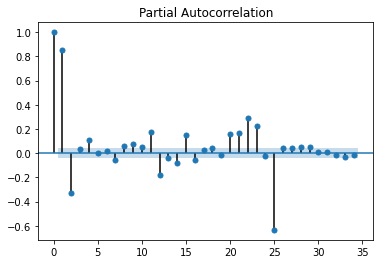

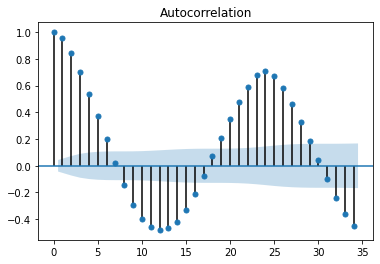

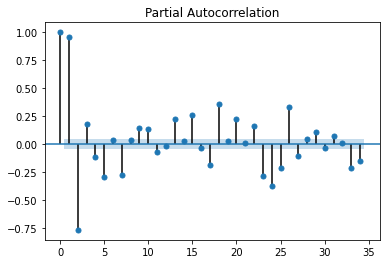

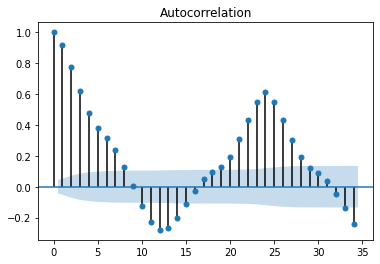

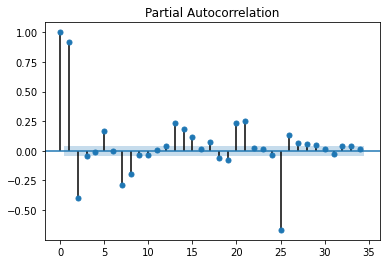

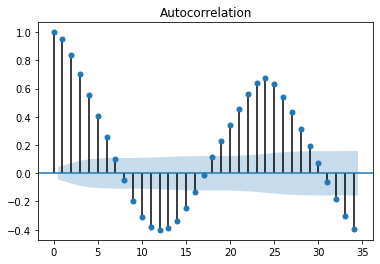

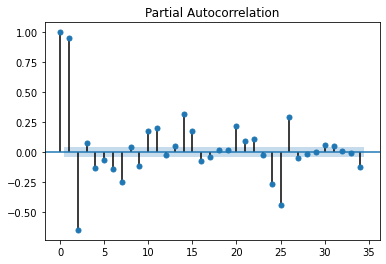

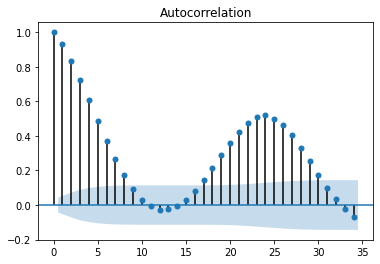

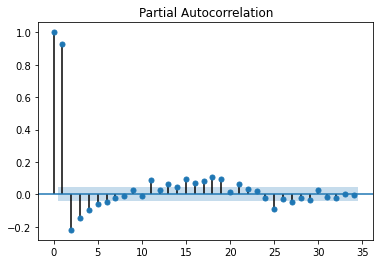

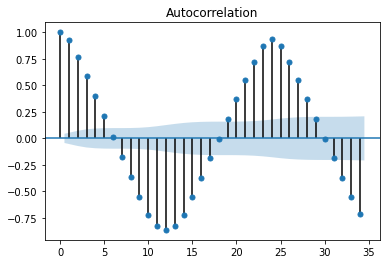

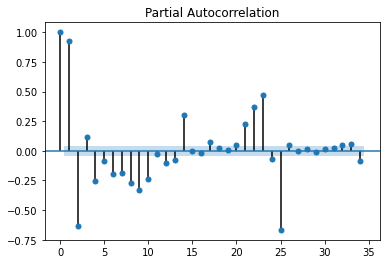

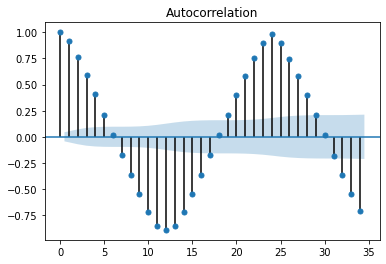

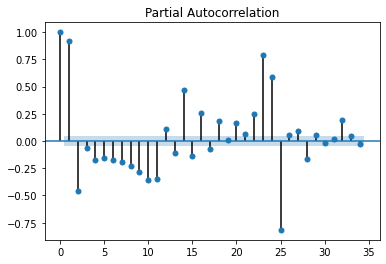

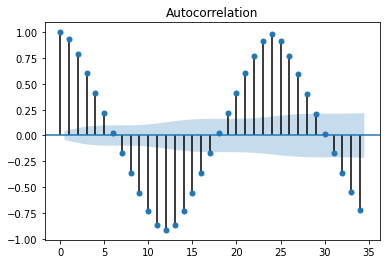

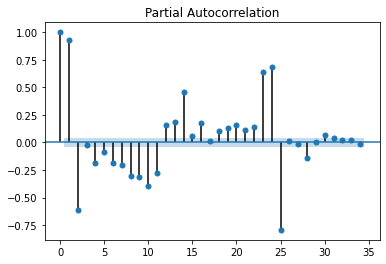

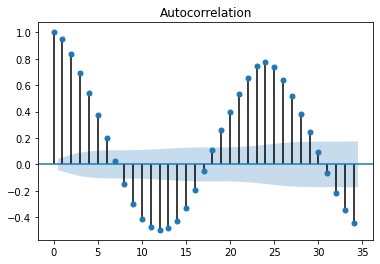

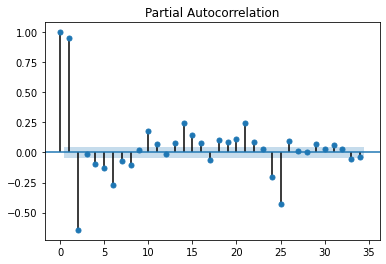

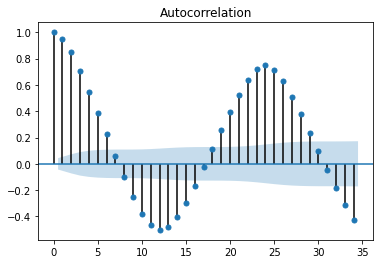

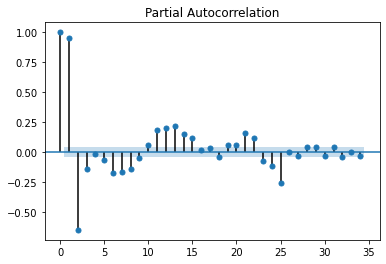

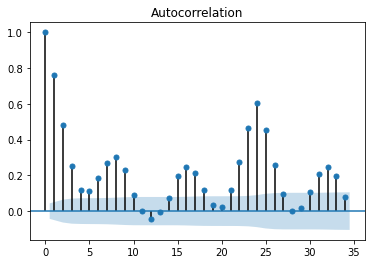

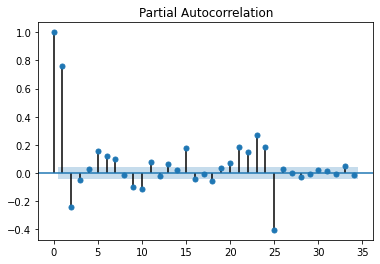

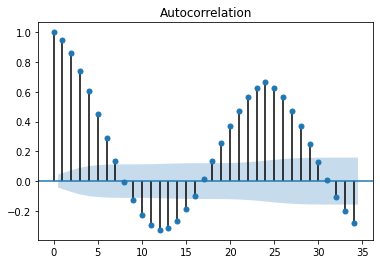

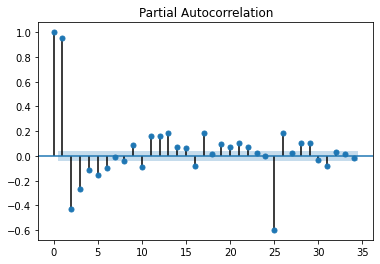

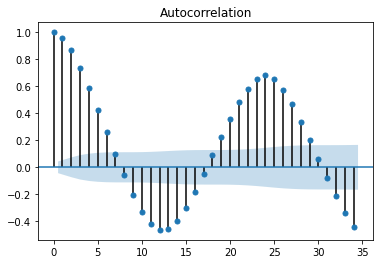

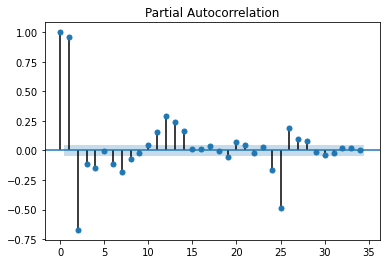

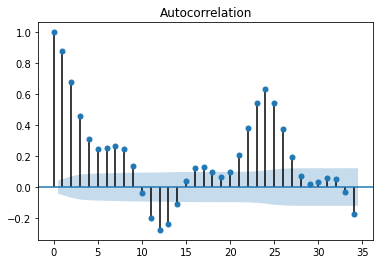

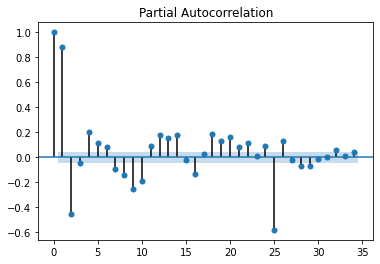

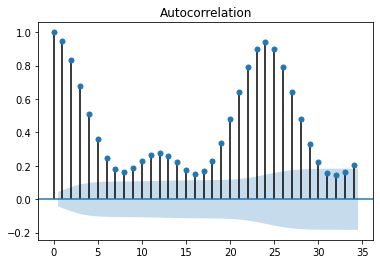

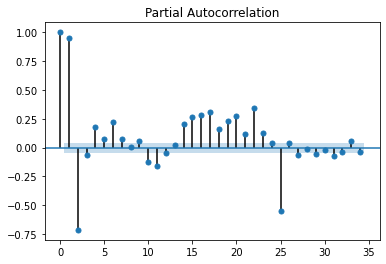

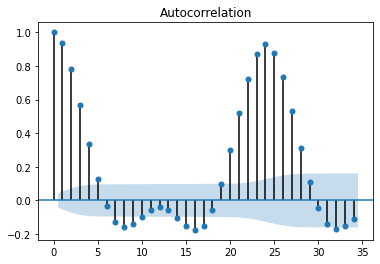

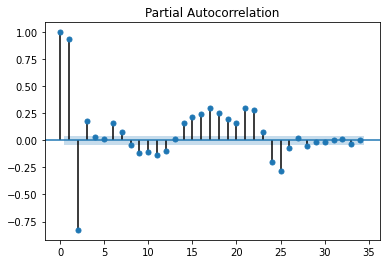

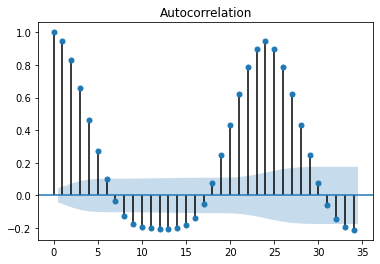

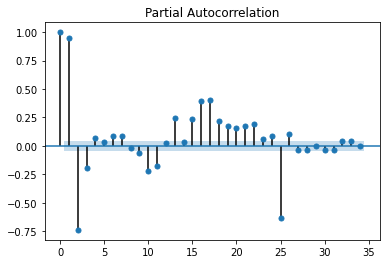

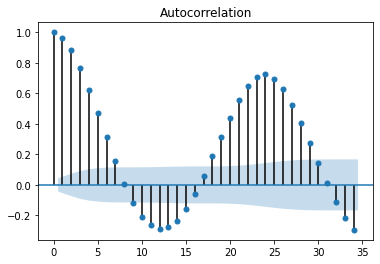

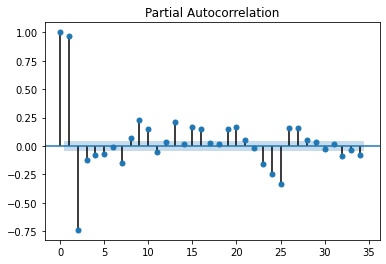

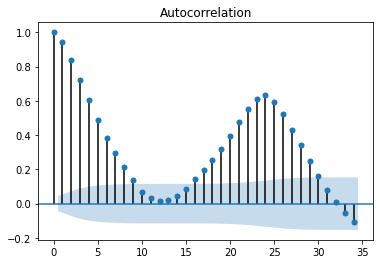

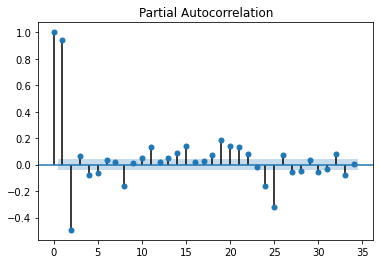

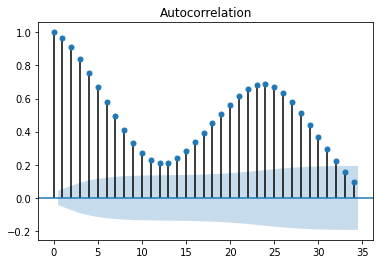

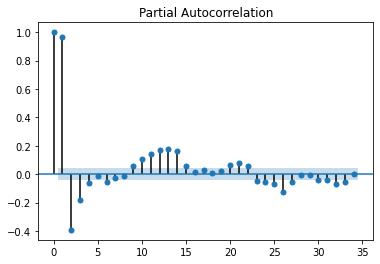

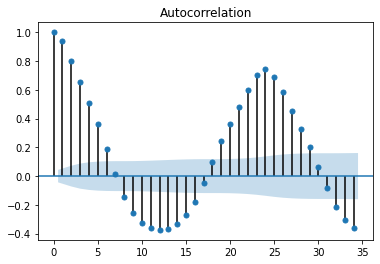

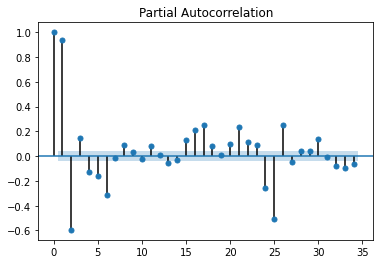

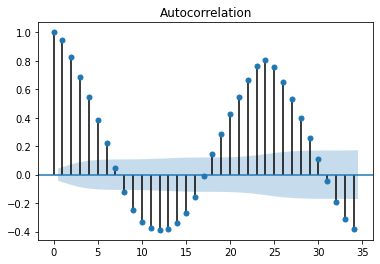

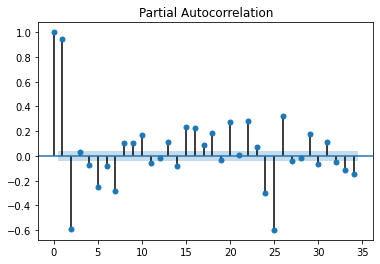

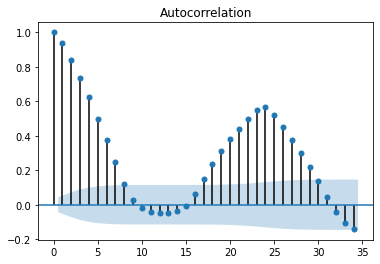

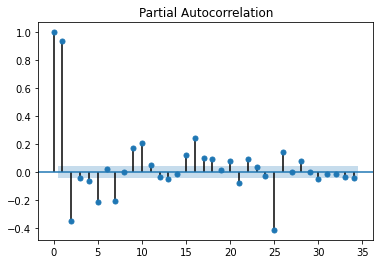

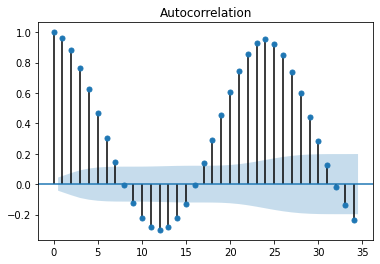

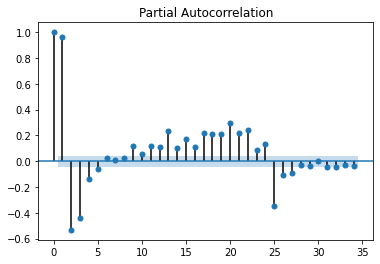

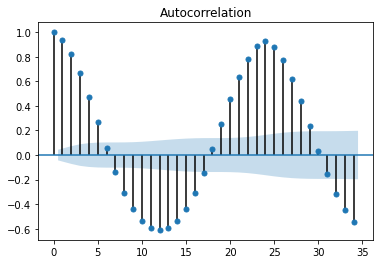

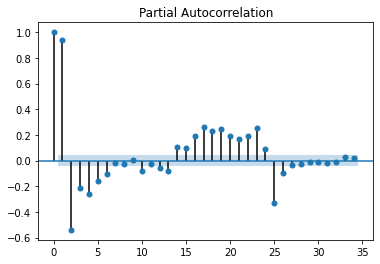

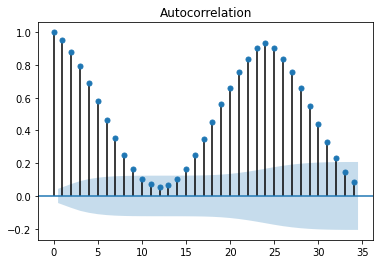

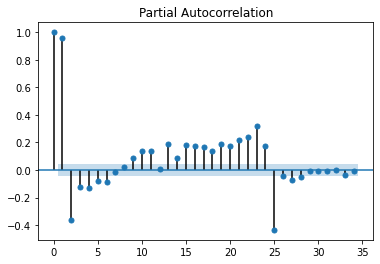

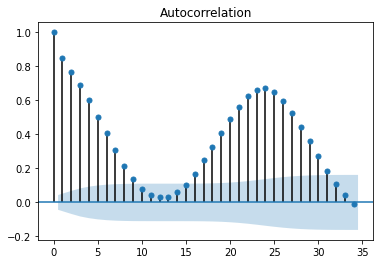

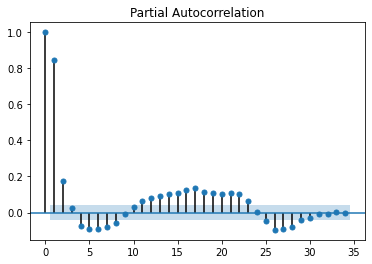

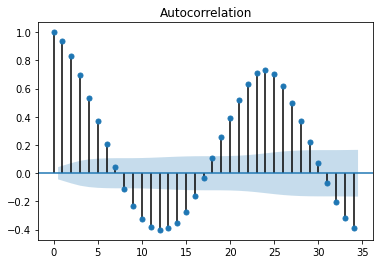

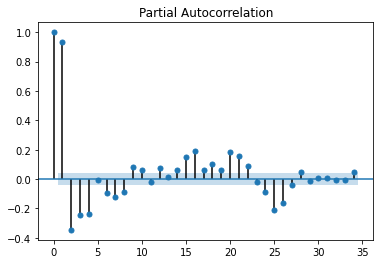

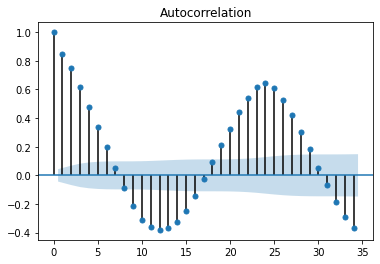

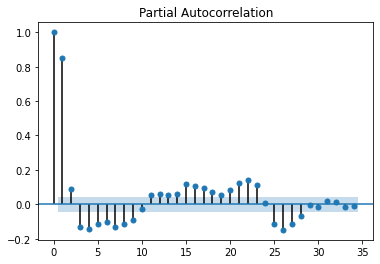

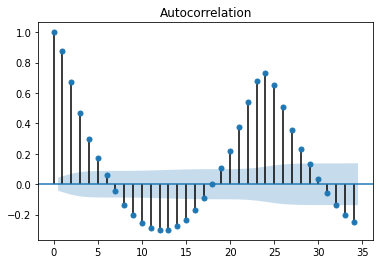

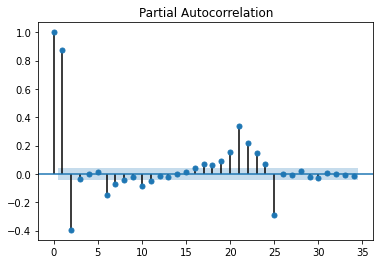

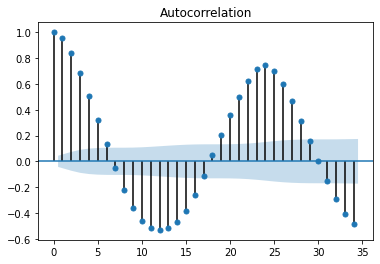

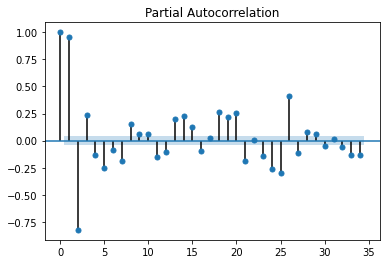

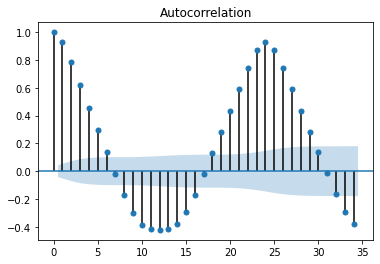

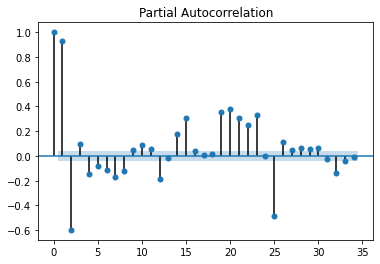

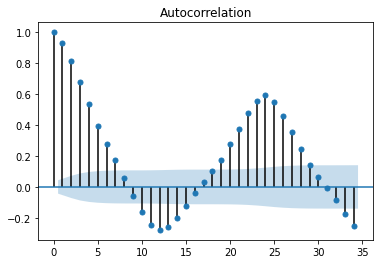

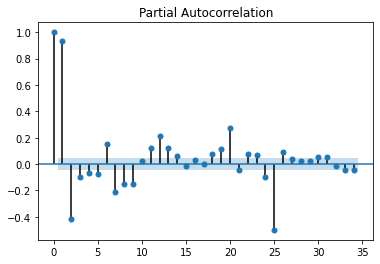

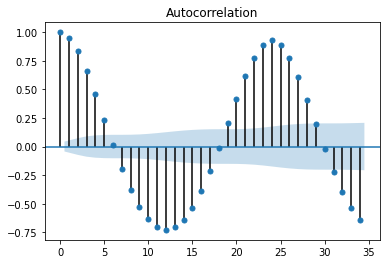

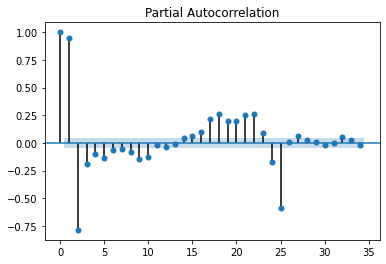

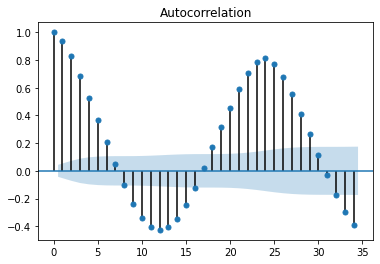

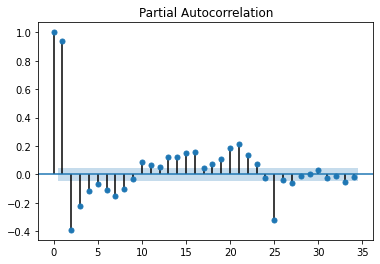

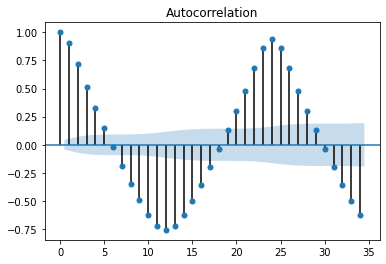

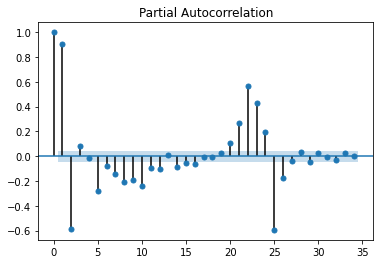

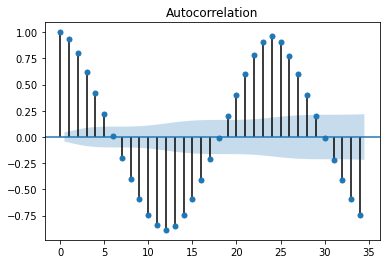

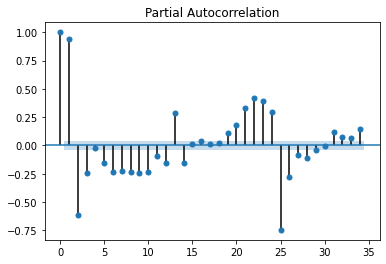

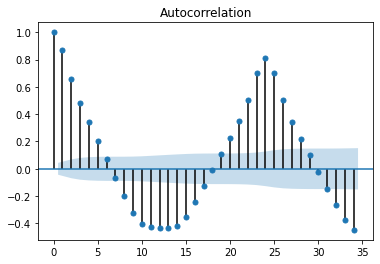

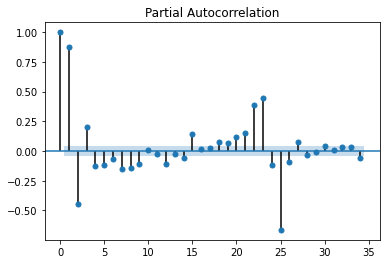

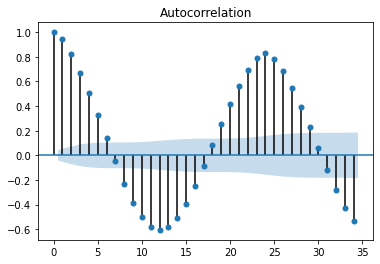

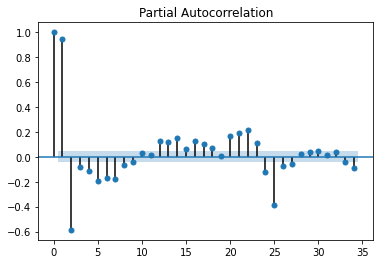

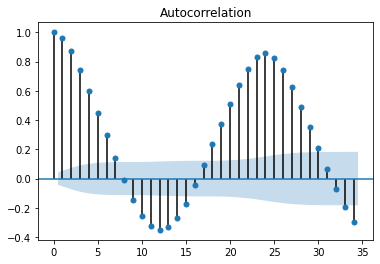

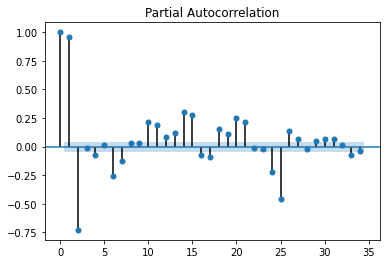

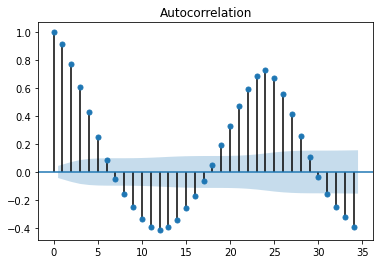

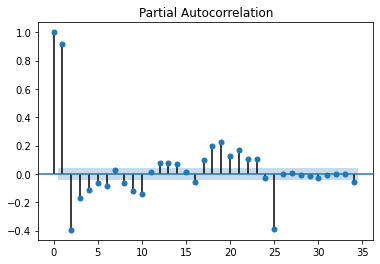

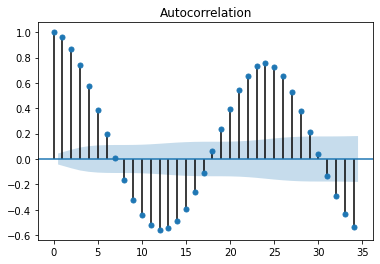

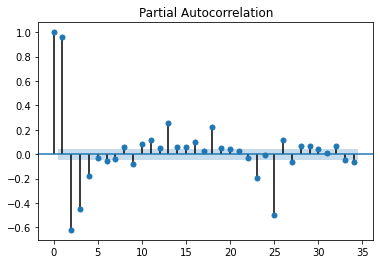

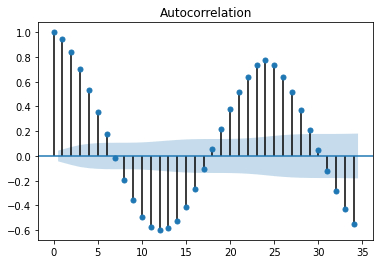

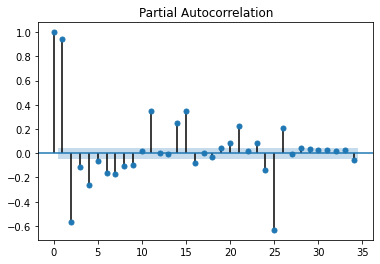

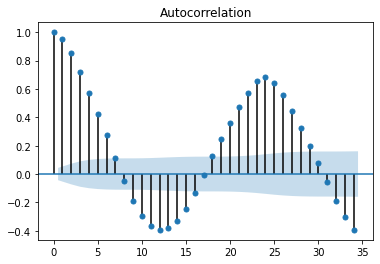

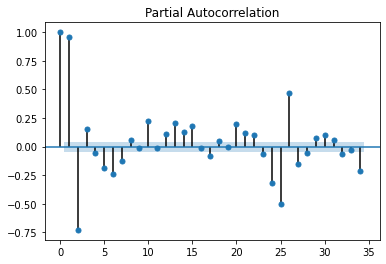

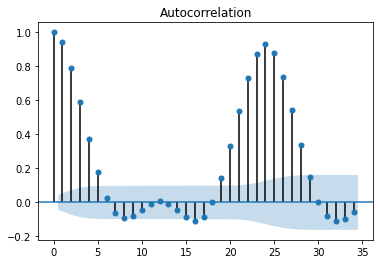

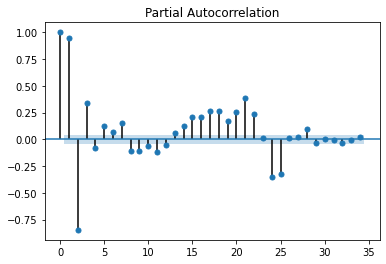

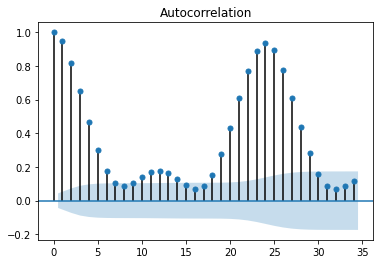

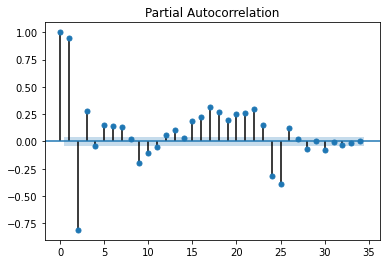

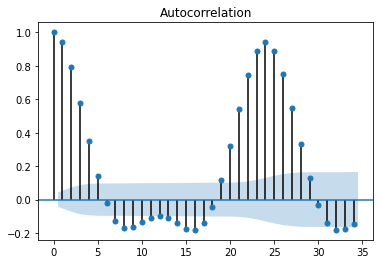

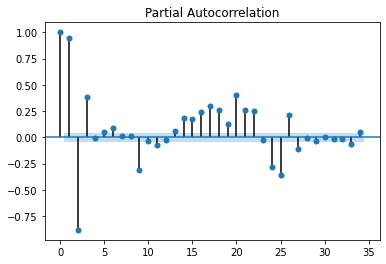

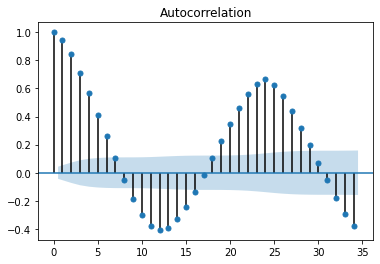

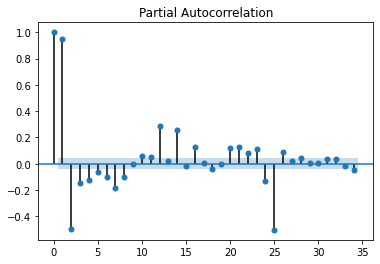

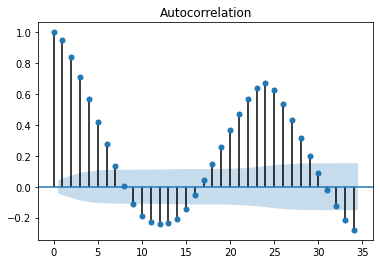

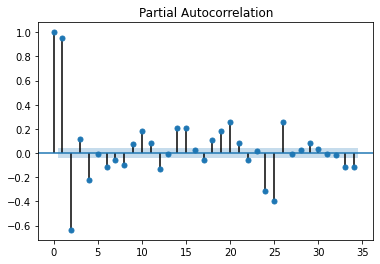

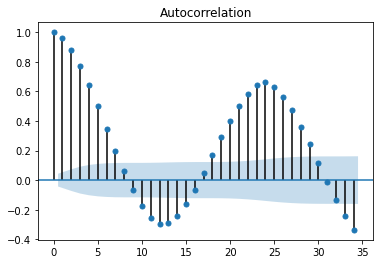

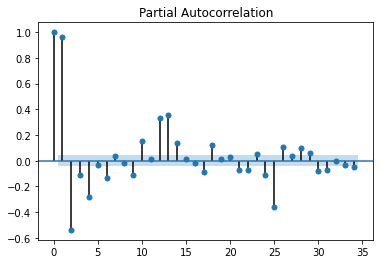

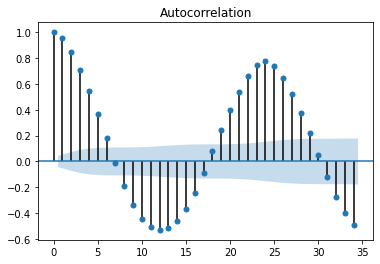

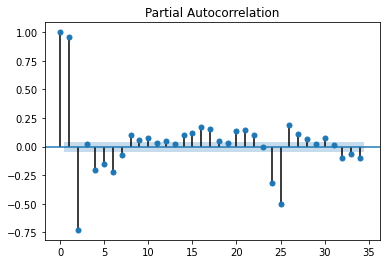

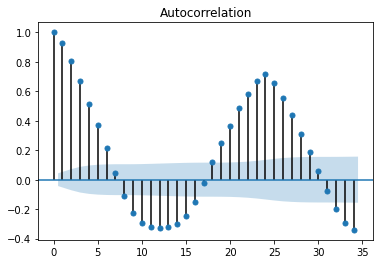

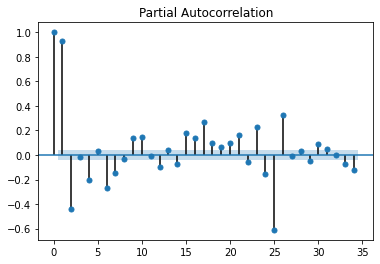

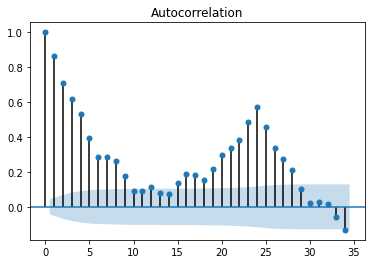

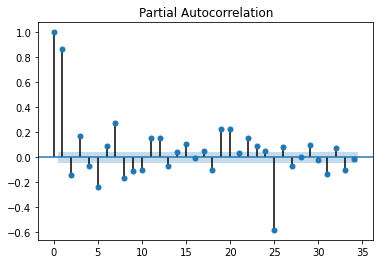

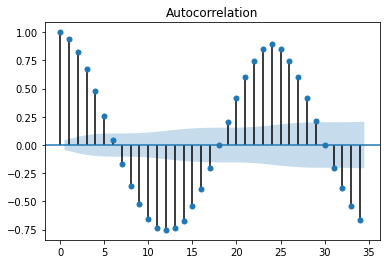

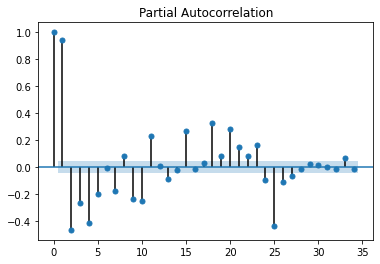

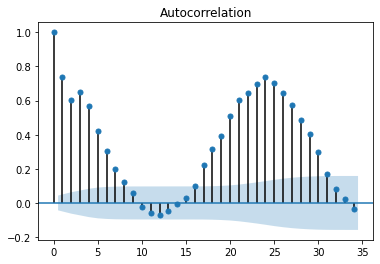

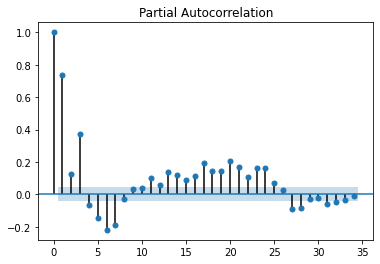

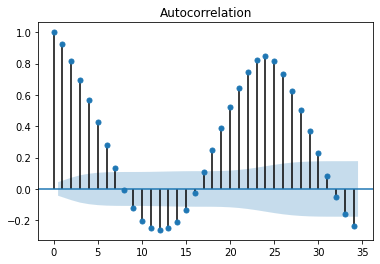

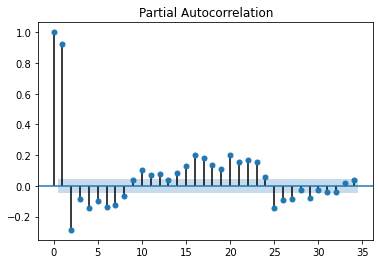

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go

for i in range(60):
  plot_acf(train[train['num']==i+1]['전력사용량(kWh)'])
  plot_pacf(train[train['num']==i+1]['전력사용량(kWh)'])


PACF 결과 대부분 1 이후 0에 수렴
-> q = 1

차분 해보기
1이나 2나 차이가 없다 뭐지.. 버근가

In [28]:
idx = 1
x_series = train_x_array[idx, :, 0]
model = ARIMA(x_series, order = (6, 0 , 1))
fit = model.fit()
preds = fit.predict(1, 168, typ= 'levels')

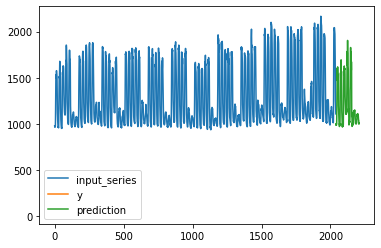

In [29]:
plt.plot(x_series, label = 'input_series')
plt.plot(np.arange(2040, 2040+168), test_x_array[idx,:,0], label = 'y')
plt.plot(np.arange(2040, 2040+168), preds, label = 'prediction')
plt.legend()

베이스라인에선 ARIMA(5, 1, 1) 아니면 4 1 1을 생각하는듯

In [30]:
valid_pred_array=np.zeros([60, 168])
for idx in range(train_x_array.shape[0]):
    try:
        try:
            x_series=train_x_array[idx, :, 0]
            model=ARIMA(x_series, order=(6, 1, 1))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=preds
        except:
            print("order 4,1,1")
            
            x_series=train_x_array[idx, :, 0]
            model=ARIMA(x_series, order=(5, 1, 1))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=preds
    except:
        print(idx, "샘플은 수렴하지 않습니다.")

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimiz

In [31]:
valid_pred_array.shape

(60, 168)

In [32]:
submission['answer']=valid_pred_array.reshape([-1,1])
submission

,num_date_time,answer
0,1 2020-08-25 00,8177.884678
1,1 2020-08-25 01,8141.513394
2,1 2020-08-25 02,8107.110867
3,1 2020-08-25 03,8048.538780
4,1 2020-08-25 04,8036.525866
...,...,...
10075,60 2020-08-31 19,3139.701471
10076,60 2020-08-31 20,3124.797826
10077,60 2020-08-31 21,3164.222122
10078,60 2020-08-31 22,2996.103154


In [33]:
submission.to_csv('sample_submission_ARIMA.csv', index=False)

위에서 ACF, PACF 보고 평균적으로 p는 6  
q는 1이 맞는 것 같고 차분이 한 번 필요해보여서 6 1 1로 진행